In [44]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


I am staring out my DS journey to practice what I have leaned so far. This competetion helped me to learn how to impute missing data and how to fine-tune the parameters for the simple ML models such as Lasso and Ridge. 

I've read some great notebooks in Kaggle. Regarding imputing missing values, I refered the notebook below.
* [Handling Missing Values](https://www.kaggle.com/dansbecker/handling-missing-values ) by DANB.
* [Using Categorical Data with One Hot Encoding](https://www.kaggle.com/dansbecker/using-categorical-data-with-one-hot-encoding) by DANB.
* [Stacked Regressions : Top 4% on LeaderBoard](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard) by Serigne.

The note below has a stragetic approach about EDA. 
* [Comprehensive data exploration with Python](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python) by PEDRO MARCELINO



In [45]:
trainingset = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
testset = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
o_submission = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
import missingno as msno
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline


import warnings
warnings.filterwarnings('ignore')

def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 

pd.set_option("display.float_format", lambda x: "{:.3f}".format(x)) #Limiting floats output to 3 decimal points

### Step1: Basic EDA

In [47]:
print(trainingset.shape)
print(testset.shape)

(1460, 81)
(1459, 80)


Note: Train and test data have missing values in diffent columns. 

In [48]:
train_null = trainingset.isnull().sum().sort_values(ascending=False)
train_null = train_null[train_null>0]

test_null = testset.isnull().sum().sort_values(ascending=False)
test_null = test_null[test_null>0]
missing_df = pd.concat([train_null,test_null, train_null/len(trainingset),test_null/len(testset), trainingset[train_null.index].dtypes, testset[test_null.index].dtypes], axis=1)
missing_df.rename({0: "train_null", 1: "test_null", 2: "train_null raito", 3: "test_null raito", 4: "dtype_train", 5: "dtype_test" },  axis='columns')

,train_null,test_null,train_null raito,test_null raito,dtype_train,dtype_test
PoolQC,1453.0,1456.0,0.995205,0.997944,object,object
MiscFeature,1406.0,1408.0,0.963014,0.965045,object,object
Alley,1369.0,1352.0,0.937671,0.926662,object,object
Fence,1179.0,1169.0,0.807534,0.801234,object,object
FireplaceQu,690.0,730.0,0.472603,0.500343,object,object
LotFrontage,259.0,227.0,0.177397,0.155586,float64,float64
GarageYrBlt,81.0,78.0,0.055479,0.053461,float64,float64
GarageCond,81.0,78.0,0.055479,0.053461,object,object
GarageType,81.0,76.0,0.055479,0.052090,object,object
GarageFinish,81.0,78.0,0.055479,0.053461,object,object


#### 1.1 Analyse target variable: SalePrice

In [49]:
trainingset.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

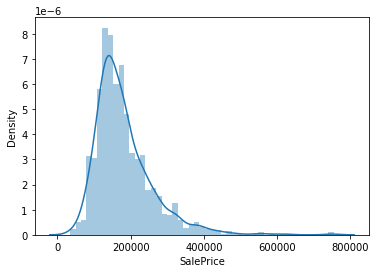

In [50]:
sns.distplot(trainingset.SalePrice)

* SalePrice has positive skewness.

In [51]:
skew = trainingset.SalePrice.skew()
kurt = trainingset.SalePrice.kurt()
print("Skew: {} /  Kurt: {}".format(skew, kurt))

Skew: 1.8828757597682129 /  Kurt: 6.536281860064529


#### 1.2 Bivariate analysis

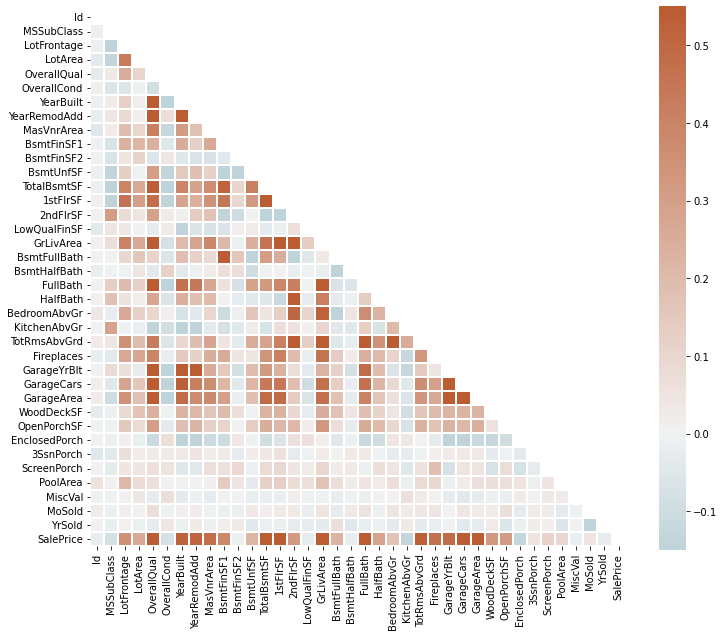

In [52]:
# Replace missging Age values based on other columns
# check correlation between different variables
matrix = trainingset.select_dtypes(exclude="object").corr()
mask = np.triu(np.ones_like(matrix, dtype=bool))
cmap = sns.diverging_palette(220, 25, s=80, n=9, as_cmap=True, center="light")
plt.figure(figsize=(12, 10))
sns.heatmap(matrix, mask = mask, annot=False, cmap=cmap, square=True, fmt='.2f',linewidth=.2, center=0, vmin=-0.15, vmax=0.55)
plt.show()


* SalePrice is highly corelated with 
'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt'

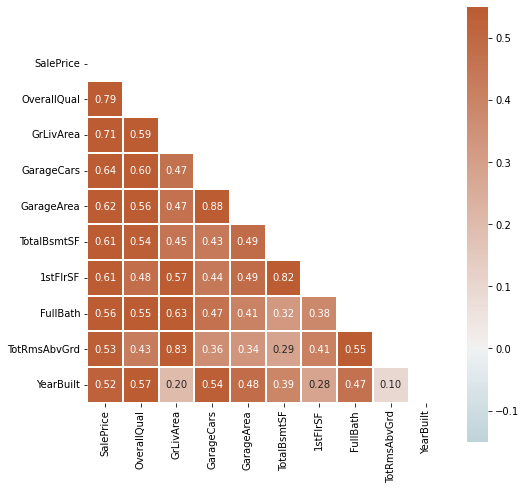

In [53]:
k = 10 #number of variables for heatmap
col_names = matrix.nlargest(k, 'SalePrice')['SalePrice'].index
coef_matrix = np.corrcoef(trainingset[col_names].values.T)
mask = np.triu(np.ones_like(coef_matrix, dtype=bool))
cmap = sns.diverging_palette(220, 25, s=80, n=9, as_cmap=True, center="light")
plt.figure(figsize=(8, 8))
sns.heatmap(coef_matrix, cbar=True, mask = mask, annot=True, cmap=cmap, square=True, fmt='.2f',linewidth=.2, center=0, vmin=-0.15, vmax=0.55, yticklabels=col_names.values, xticklabels=col_names.values)
plt.show()

* There are outliers in GrLivArea (bottom right corner), TotalBsmtSF, and 1stFlrSF
* After checking these outliers, ID 1298 is the common outliers for all three features, remove this later.
* GrLivArea also has another outlier ID 523, removing this later too.


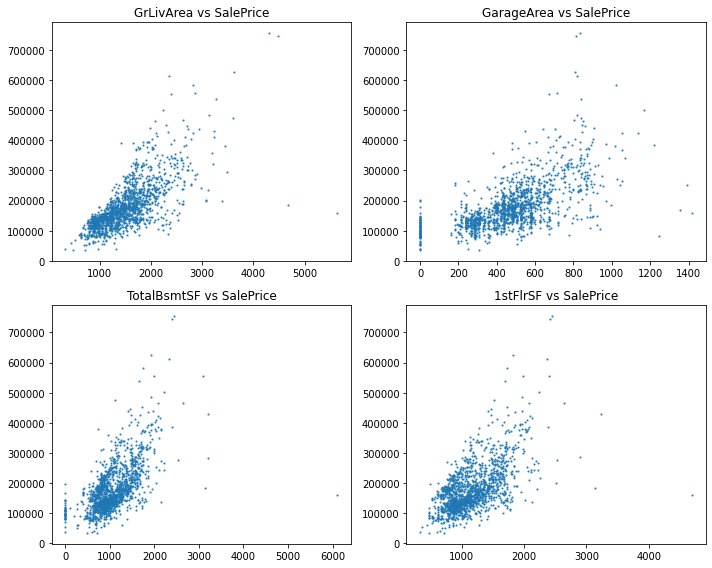

In [54]:
# plot multiple subplots to validate correlations
fig, axs = plt.subplots(2, 2, figsize=(10,8))
axs[0, 0].plot(trainingset.GrLivArea, trainingset.SalePrice, marker="o", linestyle="", markersize=1.2, alpha=.8)
axs[0, 0].set_title('GrLivArea vs SalePrice')
axs[0, 1].plot(trainingset.GarageArea, trainingset.SalePrice, marker="o", linestyle="", markersize=1.2, alpha=.8)
axs[0, 1].set_title('GarageArea vs SalePrice')
axs[1, 0].plot(trainingset.TotalBsmtSF, trainingset.SalePrice, marker="o", linestyle="", markersize=1.2, alpha=.8)
axs[1, 0].set_title('TotalBsmtSF vs SalePrice')
axs[1, 1].plot(trainingset["1stFlrSF"], trainingset.SalePrice, marker="o", linestyle="", markersize=1.2, alpha=.8)
axs[1, 1].set_title('1stFlrSF vs SalePrice')

fig.tight_layout()

<AxesSubplot:xlabel='TotRmsAbvGrd', ylabel='SalePrice'>

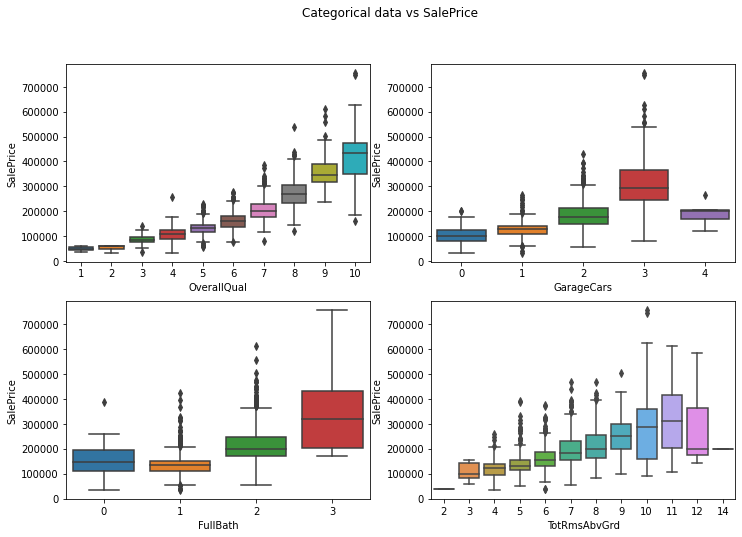

In [55]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Categorical data vs SalePrice')

sns.boxplot(ax=axes[0, 0], data=trainingset, x='OverallQual', y='SalePrice')
sns.boxplot(ax=axes[0, 1], data=trainingset, x='GarageCars', y='SalePrice')
sns.boxplot(ax=axes[1, 0], data=trainingset, x='FullBath', y='SalePrice')
sns.boxplot(ax=axes[1, 1], data=trainingset, x='TotRmsAbvGrd', y='SalePrice')




In [56]:
trainingset.YearBuilt.dtype

dtype('int64')

* Type of YearBuilt should be datetime or str. not int64. When it is an int type, the model will give more weight on this feature which is not the case here.

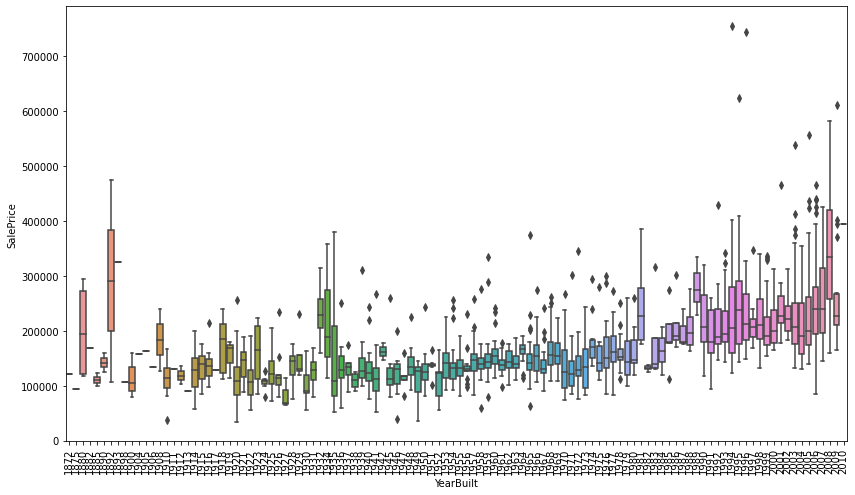

In [57]:
fig, axs = plt.subplots(figsize=(14, 8))
sns.boxplot(data=trainingset, x="YearBuilt", y="SalePrice")
plt.xticks(rotation=90)
plt.show()

In [58]:
# sns.pairplot(trainingset.loc[:,['SalePrice','GrLivArea', 'GarageArea', 'TotalBsmtSF', '1stFlrSF','TotRmsAbvGrd']])

## Data Processing

Handling Outliers

In [61]:
# removing two outliers in GrLivArea
print("Before: {}".format(trainingset.shape))
outlier_index = trainingset[(trainingset.GrLivArea > 4000) & (trainingset.SalePrice < 200000)].index
trainingset = trainingset.drop(outlier_index)
print("After: {}".format(trainingset.shape))


Before: (1460, 81)
After: (1458, 81)


<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

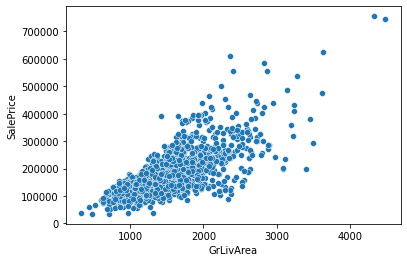

In [62]:
sns.scatterplot(trainingset.GrLivArea, trainingset.SalePrice)

In [16]:
trainingset[(trainingset["1stFlrSF"] > 4000) & (trainingset.SalePrice < 200000)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


#### Handling Skewness in data

In [ ]:
# #Before handling skewness
# #histogram and normal probability plot

# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
# sns.distplot(ax=axs[0], x=trainingset['SalePrice'], fit=norm);
# stats.probplot(x= trainingset['SalePrice'], plot=plt)
# plt.show()


In [ ]:
# #After handling skewness
# from scipy.stats import norm
# from scipy import stats
# #applying log transformation
# trainingset['SalePrice'] = np.log(trainingset['SalePrice'])

# #transformed histogram and normal probability plot
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
# sns.distplot(ax=axs[0], x=trainingset['SalePrice'], fit=norm);
# stats.probplot(x= trainingset['SalePrice'], plot=plt)
# plt.show()



In [ ]:
#data transformation
trainingset['GrLivArea'] = np.log(trainingset['GrLivArea'])
trainingset['1stFlrSF'] = np.log(trainingset['1stFlrSF'])
testset['GrLivArea'] = np.log(testset['GrLivArea'])
testset['1stFlrSF'] = np.log(testset['1stFlrSF'])
# # handle zero in TotalBsmtSF in orer to apply logorism on TotalBsmtSF
# trainingset['HasBsmt'] = pd.Series(len(trainingset['TotalBsmtSF']), index=trainingset.index)
# trainingset['HasBsmt'] = 0 
# trainingset.loc[trainingset['TotalBsmtSF']>0,'HasBsmt'] = 1
# #transform data
# trainingset.loc[trainingset['HasBsmt']==1,'TotalBsmtSF'] = np.log(trainingset['TotalBsmtSF'])


#### Check homoscedasticity

In [ ]:
# sns.scatterplot(trainingset.GrLivArea, trainingset.SalePrice) 
# sns.scatterplot(trainingset["1stFlrSF"], trainingset.SalePrice) 
# sns.scatterplot(trainingset["TotalBsmtSF"], trainingset.SalePrice) 

### Step2: Handle Missing Values

##### Notes:
* PoolQC, MiscFeature, Alley, Fence columns have more than 80% of missing values. If there are no good ways to figure out the values, I will drop these columns.
* The rest columns (FireplaceQu, Lotfrontage etc.) need to impute missing values.

In [ ]:
# columns with missing values
nullcols_train = [col for col in trainingset.columns if trainingset[col].isnull().any()]
print(len(nullcols_train), nullcols_train)

In [ ]:
# # make new columns indicating what will be imputed
# for col in cols_with_null:
#     all_data[col + "_was_missing"] = all_data[col].isnull()

# print(all_data.shape)

In [ ]:
# Visualise missing values.
# import missingno as msno
msno.matrix(trainingset.loc[:, nullcols_train])
#msno.matrix(trainingset.select_dtypes(include="object")) 

In [ ]:
# PoolQC : data description says NA means "No Pool". Replacing null with None.
# MiscFeature : data description says NA means "no misc feature". Replacing null with None.
# Alley : data description says NA means "no alley access". Replacing null with None.
# Fence: data description says NA means "no fence". Replacing null with None.
# FireplaceQu: data description says NA meand "NoFireplace". Replacing null with None.
None_cols = ["PoolQC", "MiscFeature","Alley",  "Fence", "FireplaceQu"] 
for col in None_cols:
    trainingset[col] = trainingset[col].fillna("None")
    testset[col] = testset[col].fillna("None")

In [ ]:
#### Investigate 'LotFrontage'
#Droped one outlier in LotArea(one row)  and LotFrontage (two rows)
sns.scatterplot(trainingset.LotFrontage, trainingset.LotArea)

In [ ]:
# removing outliers in LotFrontage and LotArea
trainingset = trainingset.loc[trainingset.LotArea != max(trainingset.LotArea), :] # one row
trainingset = trainingset.loc[trainingset.LotFrontage != max(trainingset.LotFrontage), :] # two rows
print("trainingset data size: {}".format(trainingset.shape))

#LotFrontage : Since the area of each street connected to the house property most likely have 
# a similar area to other houses in its neighborhood, fill in missing values by the median LotFrontage of the same neighborhood.
trainingset["LotFrontage"] = trainingset.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
testset["LotFrontage"] = testset.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [ ]:
# Features start with 'Garage' have the same number of missing data. 
# 'GarageYrBlt','GarageCond','GarageType','GarageFinish','GarageQual'
# GarageType, GarageFinish,GarageCond, GarageQual : data description says NA means "No Garage". 
# Replacing NA with "None"
garage_cols = ['GarageCond','GarageType','GarageFinish','GarageQual']
for col in garage_cols:
    trainingset[col] = trainingset[col].fillna("None")
    testset[col] = testset[col].fillna("None")
    
# GarageYrBlt: NA is due to there is no garage. Set the null data to an arbitary year number 1880.
trainingset["GarageYrBlt"] = trainingset["GarageYrBlt"].fillna("1880.0") ##???
testset["GarageYrBlt"] = testset["GarageYrBlt"].fillna("1880.0")

# impute missing values in  'GarageArea' and 'GarageCars' columns.
# data is missing because the property does not have Garage (refer GarageCond)
trainingset["GarageArea"] = trainingset["GarageArea"].fillna(0)
trainingset["GarageCars"] = trainingset["GarageCars"].fillna(0)
testset["GarageArea"] = testset["GarageArea"].fillna(0)
testset["GarageCars"] = testset["GarageCars"].fillna(0)

In [ ]:
# Features start with 'Bsmtuniquere missing same data.
# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2 : data description says NA means "No Basement". 
# Replacing NA with "None"
bsmt_cols_cate = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']
for col in bsmt_cols_cate:
    trainingset[col] = trainingset[col].fillna("None")
    testset[col] = testset[col].fillna("None")

# impute missing values in 'BsmtFullBath','BsmtHalfBath','BsmtUnfSF', 'TotalBsmtSF' columns.
# only six rows are missing and all six rows do not have a basement because BsmtQual is NA.
bsmt_cols_numerical = ['BsmtFullBath','BsmtHalfBath','BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1', 'TotalBsmtSF']
for col in bsmt_cols_numerical:
    trainingset[col] = trainingset[col].fillna(0)
    testset[col] = testset[col].fillna(0)

In [ ]:
# Electrical, MSZoning,Exterior2nd, Exterior1st, SaleType, KitchenQual: these columns have one or two missing values, 
# imputing missing values with the most common value.
most_common_cols = ["Electrical", "MSZoning", "Exterior1st", "Exterior2nd", "SaleType", "KitchenQual"]
for col in most_common_cols:
    trainingset[col] = trainingset[col].fillna(trainingset[col].mode()[0])
    testset[col] = testset[col].fillna(testset[col].mode()[0])

In [ ]:
# drop 8 null rows in the column starts with "MasVnr"
trainingset = trainingset.drop(trainingset.loc[trainingset.MasVnrType.isnull()].index) 
trainingset = trainingset.drop(trainingset.loc[trainingset.MasVnrArea.isnull()].index) 
testset["MasVnrType"] = testset["MasVnrType"].fillna("None")
testset["MasVnrArea"] = testset["MasVnrArea"].fillna(0.0)
testset["Functional"] = testset["Functional"].fillna("Typ") #data description says "Assume typical unless deductions are warranted"

In [ ]:
trainingset.groupby("Utilities").count() #1448 rows are AllPub, only 1 NoSewa, not useful to our model. Drop this column.

In [ ]:
# Remove Utilities column 
trainingset.drop("Utilities", axis=1, inplace=True)
testset.drop("Utilities", axis=1, inplace=True)

In [ ]:
#trainingset.drop("HasBsmt", axis=1, inplace=True)


In [ ]:
print(trainingset.shape)
print(testset.shape)

### Step4: Build Model

In [ ]:
# from sklearn.model_selection import cross_val_score, GridSearchCV
# from sklearn.linear_model import LinearRegression, Lasso, Ridge
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# from sklearn.compose import make_column_transformer
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.pipeline import make_pipeline

#### One Hot Encoding and Spliting data

In [ ]:
# onehotencoding
all = pd.concat([trainingset, testset], axis=0)
#cate_col = [col for col in all.columns if all[col].dtype=="object"]
all_dummy = pd.get_dummies(all)
all_dummy.shape

trainingset_ohe = all_dummy[all_dummy.Id.isin(trainingset.Id)]
testset_ohe = all_dummy[all_dummy.Id.isin(testset.Id)]

# Spliting Data
test_id = testset["Id"]
X_train = trainingset_ohe.drop(["Id","SalePrice"], axis=1)
y_train = trainingset_ohe.SalePrice
X_test = testset_ohe.drop(["Id","SalePrice"], axis=1)
y_test = o_submission.SalePrice #templary y_test data

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(len(test_id))

#### Lasso

In [65]:
def score_dataset(X_train, X_test, y_train, y_test):
    model = cv.fit(X_train, y_train)
    preds = cv.predict(X_test)
    return preds, mean_absolute_error(y_test, preds), mean_squared_error(y_test, preds)

In [ ]:
# # column_trans = make_column_transformer((OneHotEncoder(sparse=False, handle_unknown='ignore'), low_cardinality_cols_train),remainder='passthrough')
# # column_trans.fit_transform(X_train)
# sc = StandardScaler()
# reg = Lasso()    
# pipe_lasso = make_pipeline(sc, reg)

# print(pipe_lasso.get_params().keys())
# params = {"lasso__alpha": np.arange(0.1,1,0.1)}
# cv = GridSearchCV(pipe_lasso, param_grid=params)

# lasso_mae = score_dataset(X_train, X_test, y_train, y_test) 
# predictions = lasso_mae[0]
# print(lasso_mae[0])
# print(lasso_mae[1])# Losso 56143.00, 0.815
# print(cv.best_params_)
# print(cv.best_score_)

#### Ridge

In [ ]:
# column_trans = make_column_transformer((OneHotEncoder(sparse=False, handle_unknown='ignore'), low_cardinality_cols_train),remainder='passthrough')
# column_trans.fit_transform(X_train)
sc = StandardScaler()
reg = Ridge()    
pipe = make_pipeline(sc, reg)
print(pipe.get_params().keys())
params = {"ridge__alpha": np.arange(0.1,10,0.5)}
cv = GridSearchCV(pipe, param_grid=params)

ridge_mae = score_dataset(X_train, X_test, y_train, y_test) 
predictions = ridge_mae[0]
print(ridge_mae[0])
print(ridge_mae[1])# Base Ridge 56143.00, 0.815
print(cv.best_params_)
print(cv.best_score_)

### Output

In [ ]:
output_dic = {"Id": testset["Id"], "SalePrice": predictions}
output_df = pd.DataFrame(output_dic)
output_df.to_csv("submission.csv", index=False)
print("Your submission was successfully saved!")

### Experiment: Learning Curve

In [ ]:
from sklearn.model_selection import learning_curve
# Use learning curve to get training and test scores along with train sizes
train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipe, 
    X=X_train, 
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=1,
    cv=5
)

#
# Calculate training and test mean and std
#
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
#
# Plot the learning curve
#
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.grid()
plt.legend(loc='lower right')
plt.show()

### Experiment: Feature selection using Lasso

In [ ]:
# from sklearn.linear_model import Lasso
# import matplotlib.pyplot as plt 
# X_train_sc = sc.fit_transform(X_train)
# names = X_train.columns
# lasso = Lasso(alpha=0.01)
# lasso_coef = lasso.fit(X_train_sc, y_train).coef_

# # pick important features
# names_n = np.array(names)[np.abs(lasso_coef)>0]
# lasso_coef_n = lasso_coef[np.abs(lasso_coef)>0]
# print(len(names_n),len(lasso_coef_n))

# _ = plt.figure(figsize=(15,10))
# _ = plt.plot(range(len(names_n)), lasso_coef_n,  'bo-')
# _ = plt.xticks(range(len(names_n)), names_n, rotation=60)
# _ = plt.ylabel('Coefficients')
# plt.show()
